In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input 
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Add, DepthwiseConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50,VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import EarlyStopping,LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
plt.rcParams['font.size'] = 16

In [20]:
path='/kaggle/input/sports-balls-multiclass-image-classification'
train_dir='/kaggle/input/sports-balls-multiclass-image-classification/train'
test_dir='/kaggle/input/sports-balls-multiclass-image-classification/test'

In [42]:
batch_size = 32
img_size = 224

datagen=ImageDataGenerator(rescale=1/255., 
                           horizontal_flip=True,
                           vertical_flip=True,
#                             width_shift_range=0.3,
#                             height_shift_range=0.3,
                           brightness_range=[0.75,0.25],
                           rotation_range=45,
#                            zoom_range=0.05,
#                            validation_split=0.15,
                          )


train_gen=datagen.flow_from_directory(train_dir,
                                      batch_size=batch_size,
                                      target_size=(img_size, img_size), 
                                      shuffle=True,
                                      class_mode='categorical',
#                                       subset='training',


)

valdata=ImageDataGenerator(rescale=1/255.)
val_gen=valdata.flow_from_directory(test_dir,
                                      batch_size=batch_size,
                                      target_size=(img_size, img_size), 
                                      shuffle=False,
                                      class_mode='categorical',
#                                       subset='validation',


)

Found 7328 images belonging to 15 classes.
Found 1841 images belonging to 15 classes.


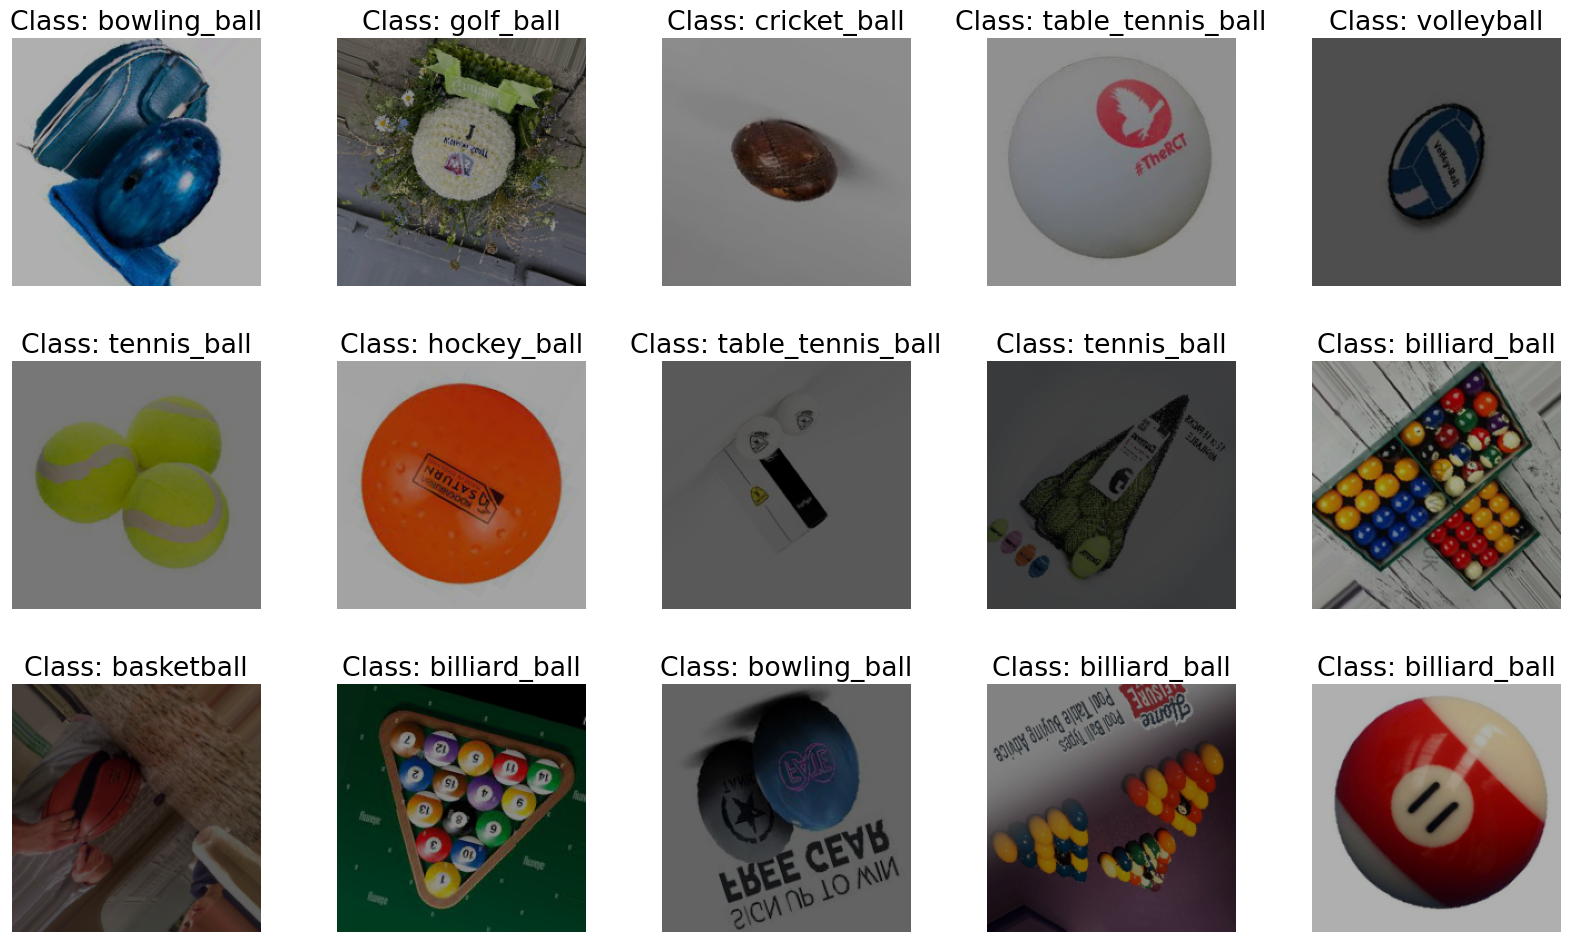

In [43]:
labels = [k for k in train_gen.class_indices]
sample_generate = train_gen.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [44]:
# base_model_resnet=ResNet50(weights='imagenet',
#                            include_top=False,
#                            input_shape=(224,224,3)
# )

In [53]:
base_model_VGG16=VGG16(weights='imagenet',
                           include_top=False,
                           input_shape=(224,224,3)
)

In [55]:
# base_model_VGG16.summary()

In [25]:
index = None
for idx, layer in enumerate(base_model_resnet.layers):
    if layer.name == 'conv3_block4_out (Activation) ':
        index = idx
        break


In [56]:
layer_names = [layer.name for layer in base_model_VGG16.layers]
layer_idx = layer_names.index('block2_pool')

In [57]:
layer_idx

6

In [45]:
for layer in base_model_resnet.layers[:-28]:
    layer.trainable=False

In [58]:
for layer in base_model_VGG16.layers[:-6]:
    layer.trainable=False

In [59]:
base_model_resnet.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [61]:
last_output = base_model_VGG16.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(15, activation='softmax')(x)
model = Model(inputs=base_model_VGG16.inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [62]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

In [63]:
try:
    history = model.fit(train_gen,
                        epochs=5,
                        validation_data=val_gen,
                        callbacks=[checkpoint,earlystopping])
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/5
229/229 [==============================] - ETA: 0s - loss: 2.2296 - accuracy: 0.2860
Epoch 1: val_loss improved from inf to 1.61454, saving model to model.h5
229/229 [==============================] - 161s 679ms/step - loss: 2.2296 - accuracy: 0.2860 - val_loss: 1.6145 - val_accuracy: 0.5215
Epoch 2/5
229/229 [==============================] - ETA: 0s - loss: 1.5380 - accuracy: 0.5367
Epoch 2: val_loss improved from 1.61454 to 1.11280, saving model to model.h5
229/229 [==============================] - 155s 677ms/step - loss: 1.5380 - accuracy: 0.5367 - val_loss: 1.1128 - val_accuracy: 0.6844
Epoch 3/5
229/229 [==============================] - ETA: 0s - loss: 1.2948 - accuracy: 0.6251
Epoch 3: val_loss improved from 1.11280 to 1.10083, saving model to model.h5
229/229 [==============================] - 155s 676ms/step - loss: 1.2948 - accuracy: 0.6251 - val_loss: 1.1008 - val_accuracy: 0.6860
Epoch 4/5
229/229 [==============================] - ETA: 0s - loss: 1.1061 - accur

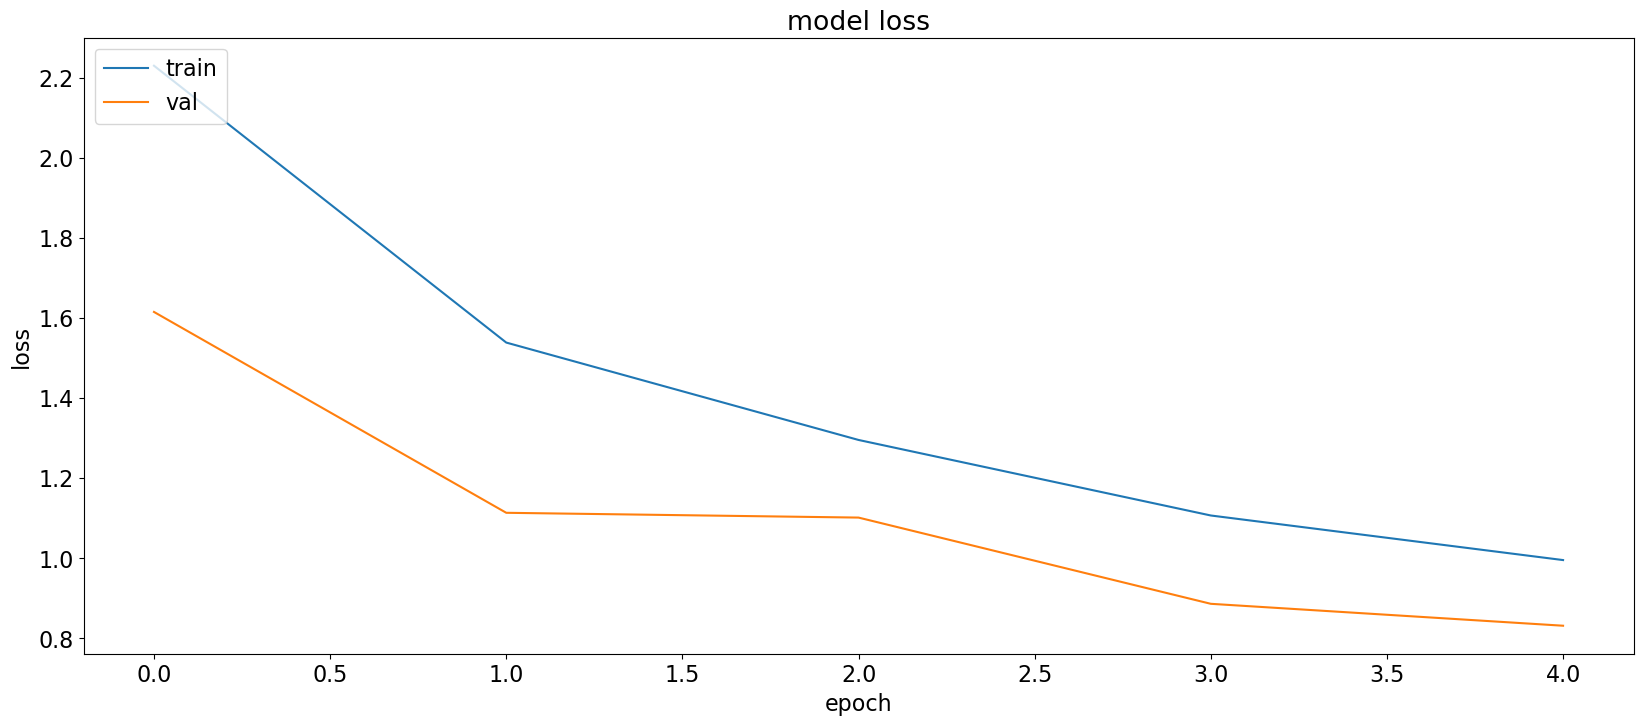

In [64]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


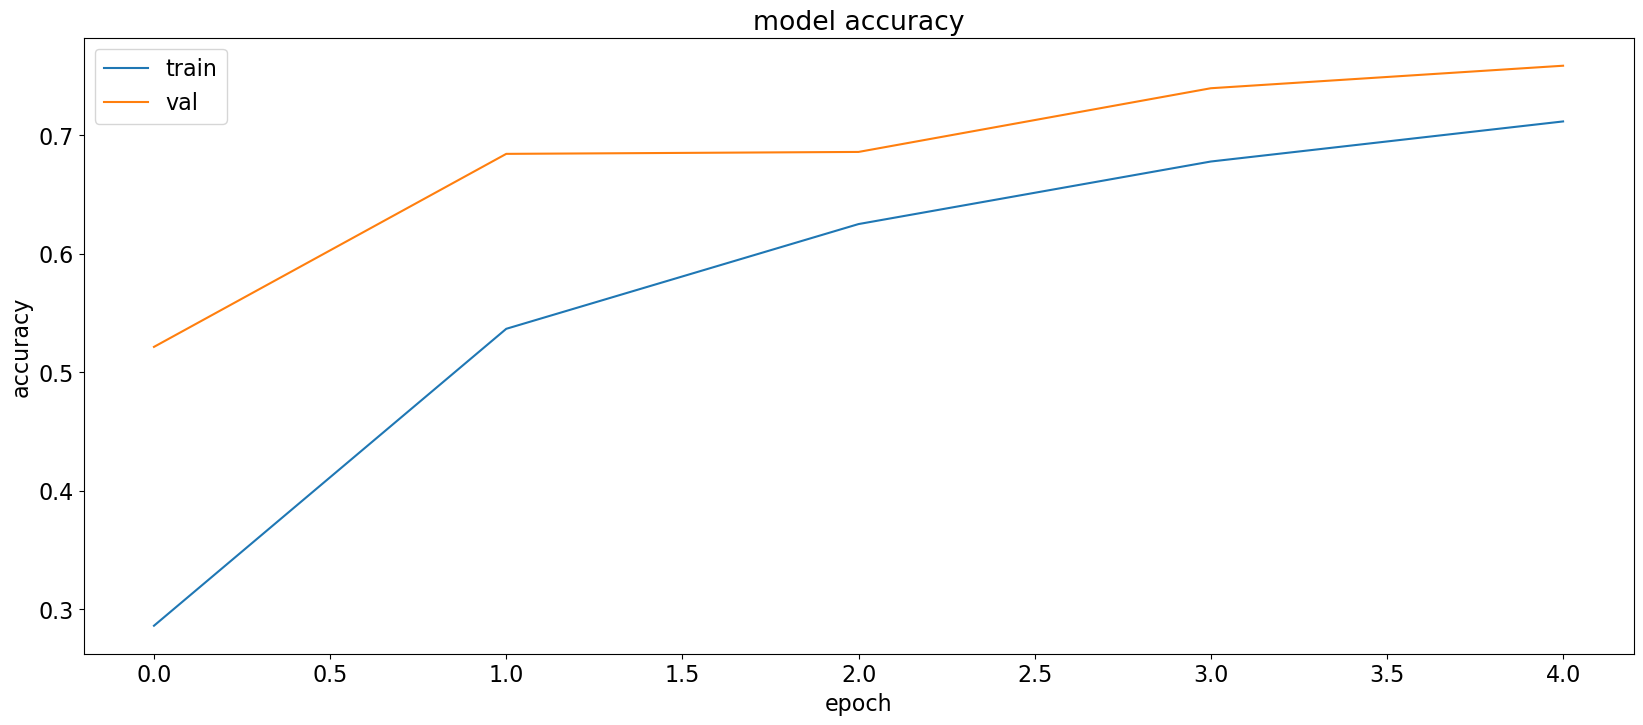

In [65]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [68]:
best_model=tf.keras.models.load_model('model.h5')

In [70]:
y_test = val_gen.classes
y_pred_val = best_model.predict(val_gen)
y_pred_val = np.argmax(y_pred_val,axis=1)
# y_pred_test = best_model.predict(val_gen,axis=1)
# y_pred_test = np.argmax(y_pred_test,axis=1)

58/58 [==============================] - 16s 272ms/step


In [71]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred_val,target_names = labels))

                   precision    recall  f1-score   support

american_football       0.75      0.85      0.80        96
         baseball       0.87      0.80      0.83       100
       basketball       0.77      0.84      0.80        86
    billiard_ball       0.90      0.81      0.85       162
     bowling_ball       0.77      0.64      0.70       111
     cricket_ball       0.94      0.76      0.84       146
         football       0.77      0.90      0.83       151
        golf_ball       0.73      0.72      0.73       138
      hockey_ball       0.49      0.65      0.55       133
      hockey_puck       0.59      0.65      0.62        98
       rugby_ball       0.77      0.74      0.76       124
      shuttlecock       0.81      0.89      0.85       108
table_tennis_ball       0.67      0.74      0.71       156
      tennis_ball       0.85      0.76      0.80       123
       volleyball       0.93      0.61      0.74       109

         accuracy                           0.76      